# 3D model example

This notebook presents a full 3D model, purely synthetical, using various capabilities of ArchPy such as Truncated plurigaussian for filling and physical properties conditioning.

In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
pv.set_jupyter_backend('static')
import sys

#For loading ArchPy, the path where ArchPy is must be added with sys
sys.path.append("../../")
#my modules
from ArchPy.base import * #ArchPy main functions 
from ArchPy.tpgs import * #Truncated plurigaussians

In [2]:
PB = Pile(name = "PB",seed=1)
P1 = Pile(name="P1",seed=1)

In [3]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x1 = 20
y1 = 10
z1 = -6
x0 = 0
y0 = 0
z0 = -15
nx = 133
ny = 67
nz = 62


dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

[0.19104429 0.26419991 0.19104429 0.35371151]


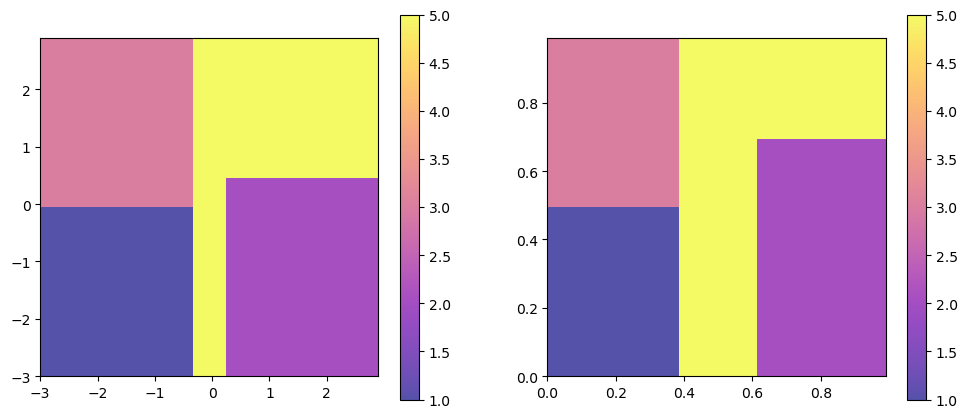

In [4]:
## setup TPGs for B units

#flag
#thresholds
t2g1 = -0.3
t3g1 = .3
t1g2 = 0
t2g2 = 0.5

#dictionnaries show where a certain facies is present. 
# The structure is a list of list containing 2 tuples of size 2 that indicates the limits of the gaussian fields
# e.g. [[(lower_boundary1_g1,upper_boundary1_g1),(lower_boundary1_g2,upper_boundary1_g2)]] --> this indicates one cuboid and multiple can be defined
dic1 = [[(-np.inf,t2g1),(-np.inf,t1g2)]] # this facies is present between -inf to -0.3 of the 1st gaussian field and between -inf to 0 of the 2
dic2 = [[(t3g1,np.inf),(-np.inf,t2g2)]]
dic3 = [[(-np.inf,t2g1),(t1g2,np.inf)]]
dic4 = [[(t2g1,t3g1),(-np.inf,np.inf)],[(t3g1,np.inf),(t2g2,np.inf)]]

flag = {1:dic1,
        2:dic2,
        3:dic3,
        5:dic4}
print(ArchPy.tpgs.pfa(flag))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_flag(flag,alpha=.7)

plt.subplot(1,2,2)
plot_flag(Gspace2Pspace(flag),alpha=.7)

## G_cm
G1 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[50,50,20]}),
                         ("nugget",{"w":0.0})],name="G1")
G2 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[50,50,20]}),
                         ("nugget",{"w":0.0})],name="G2",alpha=30)
G_cm = [G1,G2]

In [5]:
#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[60,60]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[80,80]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[60,60]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[100,100]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[10,10,3]})],alpha=0,name="vario_SIS") # input variogram
covmodel_SIS_D = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[5,5,5]})],alpha=0,name="vario_SIS") # input variogram
lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelD=[covmodel_SIS_D]


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method" : "TPGs","Flag" : flag,"G_cm":G_cm,"grf_method":"sgs"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC}
dic_f_C = {"f_method" : "SIS","neig" : 10,"f_covmodel":covmodel_SIS_C}
C = Unit(name="C",order=2,ID = 2,color="blue",contact="onlap",dic_facies=dic_f_C,surface=Surface(dic_surf=dic_s_C,contact="onlap"))

dic_s_er2 = {"int_method" : "grf","covmodel" : covmodel_er}
erosion2 = Surface(dic_surf=dic_s_er2, contact="erode")
#er2 = Unit(name="erosion2",ID = 4, order=4,contact="erode",color="black",surface=Surface(dic_surf = dic_s_er2,contact="erode"))         

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB}
dic_f_B = {"f_method":"SubPile","SubPile":PB}
B = Unit(name="B",order=3,ID = 3,color="green",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

# PB
ds_B3 = {"int_method":"grf_ineq","covmodel":covmodelB}
df_B3 = {"f_method":"SIS","neig" : 10,"f_covmodel":covmodel_SIS_D}
B3 = Unit(name = "B3",order=1,ID = 6,color="forestgreen",surface=Surface(dic_surf=ds_B3,contact="onlap"),dic_facies=df_B3)

ds_B2 = {"int_method":"grf_ineq","covmodel":covmodelB}
df_B2 = {"f_method":"SIS","neig" : 10,"f_covmodel":covmodel_SIS_D}
B2 = Unit(name = "B2",order=2,ID = 7,color="limegreen",surface=Surface(dic_surf=ds_B2,contact="erode"),dic_facies=df_B2)

ds_B1 = {"int_method":"grf_ineq","covmodel":covmodelB}
df_B1 = {"f_method":"SIS","neig" : 10,"f_covmodel":covmodel_SIS_D}
B1 = Unit(name = "B1",order=3, ID = 8,color="palegreen",surface=Surface(dic_surf=ds_B1,contact="onlap"),dic_facies=df_B1)

## Subpile
PB.add_unit([B3,B2,B1])

Unit D: Surface added for interpolation
Unit C: covmodel for SIS added
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added
Unit B3: covmodel for SIS added
Unit B3: Surface added for interpolation
Unit B2: covmodel for SIS added
Unit B2: Surface added for interpolation
Unit B1: covmodel for SIS added
Unit B1: Surface added for interpolation
Stratigraphic unit B3 added
Stratigraphic unit B2 added
Stratigraphic unit B1 added


In [6]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[5,5,1]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[3,3,1]})],alpha=0,name="K_vario_2")
covmodelPoro = gcm.CovModel3D(elem=[("exponential",{"w":0.005,"r":[10,10,10]})],alpha=0,name="poro_vario")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1,facies_2,facies_3,facies_5])
D.add_facies([facies_1,facies_2,facies_3,facies_5])
C.add_facies([facies_4,facies_6])
#add same facies than B
for b in PB.list_units:
    b.add_facies(B.list_facies)

permea = Prop("K",[facies_1,facies_2,facies_3,facies_4,facies_5,facies_6,facies_7],
                  [covmodelK2,covmodelK,covmodelK,None,covmodelK2,covmodelK,None],
                  means=[-3.5,-2,-4.5,-8,-5.5,-6.5,-10],
                  int_method = ["sgs","sgs","sgs","homogenous","sgs","sgs","homogenous"],
                  def_mean=-5)
poro = Prop("Porosity",
            [facies_1,facies_3,facies_4],
            [covmodelPoro,covmodelPoro,covmodelPoro],
             means = [0.4,0.3,0.2],
             int_method = ["sgs","sgs","sgs"],
             def_mean=0.3,
             vmin=0)

Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Facies Sand added to unit D
Facies Gravel added to unit D
Facies GM added to unit D
Facies SM added to unit D
Facies Clay added to unit C
Facies Silt added to unit C
Facies Sand added to unit B3
Facies Gravel added to unit B3
Facies GM added to unit B3
Facies SM added to unit B3
Facies Sand added to unit B2
Facies Gravel added to unit B2
Facies GM added to unit B2
Facies SM added to unit B2
Facies Sand added to unit B1
Facies Gravel added to unit B1
Facies GM added to unit B1
Facies SM added to unit B1


In [7]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [8]:
#logs strati
log_strati1 = [(C,-6.01),(B3,-8),(B2,-9),(B1,-9.5),(A,-10)]
log_strati2 = [(C,-6.01),(B3,-8.5),(B2,-9.5),(A,-10.5)]
log_strati3 = [(D,-6.01),(B3,-8),(B2,-8.5),(B1,-9.5),(A,-10.5)]
log_strati4 = [(D,-6.01),(B3,-9),(B2,-10),(A,-11)]
log_strati5 = [(D,-6.01),(C,-10),(A,-12)]
log_strati6 = [(D,-6.01),(A,-9)]

# logs facies
log_facies1 = [(facies_4,-6.01),(facies_6,-6.5),(facies_4,-7),(facies_6,-7.5), # facies in unit C
               (facies_1,-8),(facies_5,-8.5),(facies_2,-9),(facies_3,-9.3),  # facies in unit B
               (facies_7,-10)]
log_facies2 = [(facies_4,-6.01),(facies_6,-7.3),(facies_4,-7.6),(facies_6,-8),
               (facies_2,-8.5),(facies_1,-8.8),(facies_2,-9),(facies_3,-9.2),(facies_1,-10),
               (facies_7,-10.5)]
log_facies3 = [(facies_1,-6.015),(facies_2,-6.8),(facies_5,-7),(facies_3,-7.3),(facies_1,-7.5),
               (facies_2,-8),(facies_1,-8.8),(facies_2,-9),(facies_3,-9.2),(facies_1,-10),
              (facies_7,-10.5)]
log_facies4 = [(facies_1,-6.01),(facies_2,-7.5),(facies_5,-7.8),(facies_3,-8),(facies_5,-8.3),(facies_1,-8.7),
               (facies_2,-9),(facies_1,-10),(facies_2,-10.5),
               (facies_7,-11)]
log_facies5 = [(facies_5,-6.01),(facies_1,-7.5),(facies_3,-7.8),(facies_2,-8),(facies_1,-8.3),(facies_2,-8.7),(facies_1,-9),(facies_5,-9.5),
               (facies_4,-10),(facies_6,-10.4),(facies_4,-11),
               (facies_7,-12)]
log_facies6 = [(facies_1,-6.01),(facies_2,-8.3),(facies_3,-8.5),(facies_2,-8.7),
               (facies_7,-9)]

#create boreholes
bh1 = borehole("b1",1,x=10*1,y=10*5,z=log_strati1[0][1],depth =9,log_strati=log_strati1,log_facies=log_facies1)
bh2 = borehole("b2",2,x=10*3,y=10*2,z=log_strati2[0][1],depth =8,log_strati=log_strati2,log_facies=log_facies2)
bh3 = borehole("b3",3,x=10*5,y=10*6,z=log_strati3[0][1],depth =7,log_strati=log_strati3,log_facies=log_facies3)
bh4 = borehole("b4",4,x=10*10,y=10*1,z=log_strati4[0][1],depth =8,log_strati=log_strati4,log_facies=log_facies4)
bh5 = borehole("b5",5,x=10*15,y=10*3,z=log_strati5[0][1],depth =8,log_strati=log_strati5,log_facies=log_facies5)
bh6 = borehole("b6",6,x=10*19,y=10*9,z=log_strati6[0][1],depth =6,log_strati=log_strati6,log_facies=log_facies6)

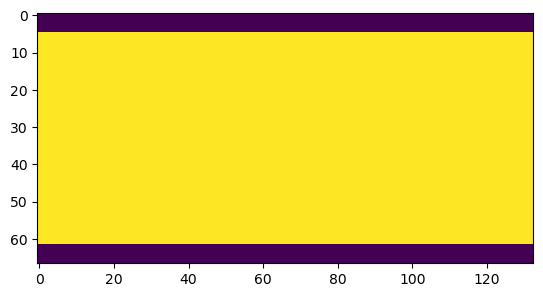

In [9]:
domain = np.ones([ny,nx],dtype=bool)
domain[: 5]= 0
domain[-5:] = 0
plt.imshow(domain)

In [10]:
T1 = Arch_table(name = "P1",seed=1)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot,polygon=domain)
T1.rem_all_bhs()
T1.add_bh([bh1,bh2,bh3,bh4,bh5,bh6])
T1.add_prop([permea])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
boreholes removed
Borehole 1 goes below model limits, borehole 1 depth cut
Borehole 1 added
Borehole 2 added
Borehole 3 added
Borehole 4 added
Borehole 5 added
Borehole 6 added
Property K added


In [11]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
Discrepency in the orders for units A and B
Changing orders for that they range from 1 to n
Pile PB: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
First altitude in log facies of bh 3 is not set at the top of the borehole, altitude changed

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


In [12]:
T1.compute_surf(1)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0295107364654541 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0534517765045166 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.06682133674621582 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.08330321311950684 s
##########################

########## PILE PB ##########
Pile PB: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT B1
B1: time elapsed for computing surface 0.0443875789642334 s

#### COMPUTING SURFACE OF UNIT B2
B2: time elapsed for computing surface 0.017006397247314453 s

#### COMPUTING SURFACE OF UNIT B3
B3: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.061945199966430664 s
#########

### Plotting units

ArchPy integrates multiple plotting utilities that mostly rely on Pyvista and Geone.
Below are some examples

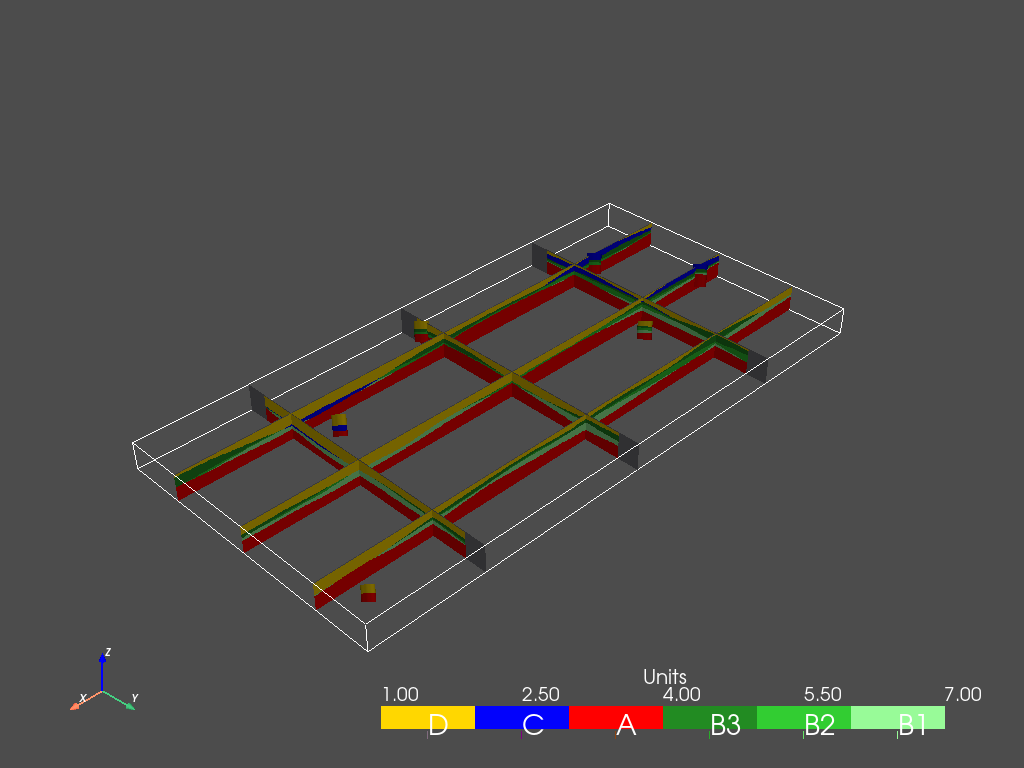

In [13]:
p = pv.Plotter()
v_ex = 1

T1.plot_units(0, v_ex=v_ex, plotter=p, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))
T1.plot_bhs(plotter=p, v_ex=v_ex)
p.show()

### Cross-sections

ArchPy integrates the possibility to make cross-section, interactively or not.
You can pass a list of point where to draw the cross-section. Boreholes are projected on the cross-section if they are at a distance less than ``dist_max``. You can choose which realization to plot with ``iu`` parameter. The width of the boreholes can be set with ``width`` parameter.

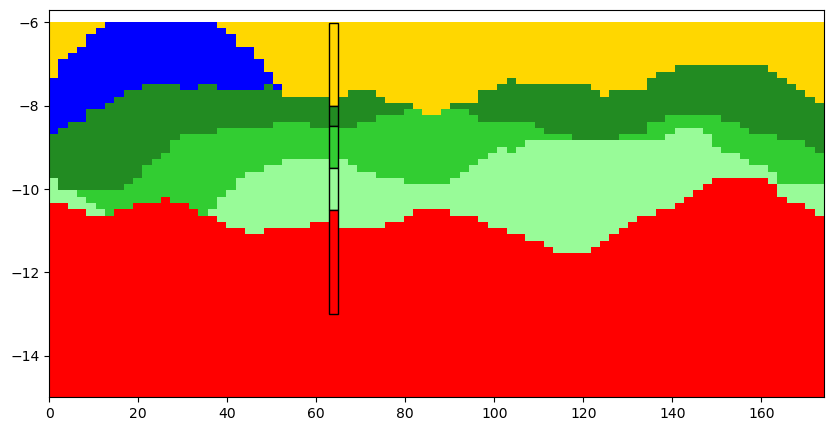

In [21]:
#cross section
#first a list of points must be defined
p1 = [10,10]
p2 = [50,70]
p3 = [150,90]
T1.plot_cross_section([p1,p2,p3],iu=0,ratio_aspect=2, dist_max=10, width=2)

ArchPy also integrates probability plotting functions which allow to plot any ArchPy object such as units or facies

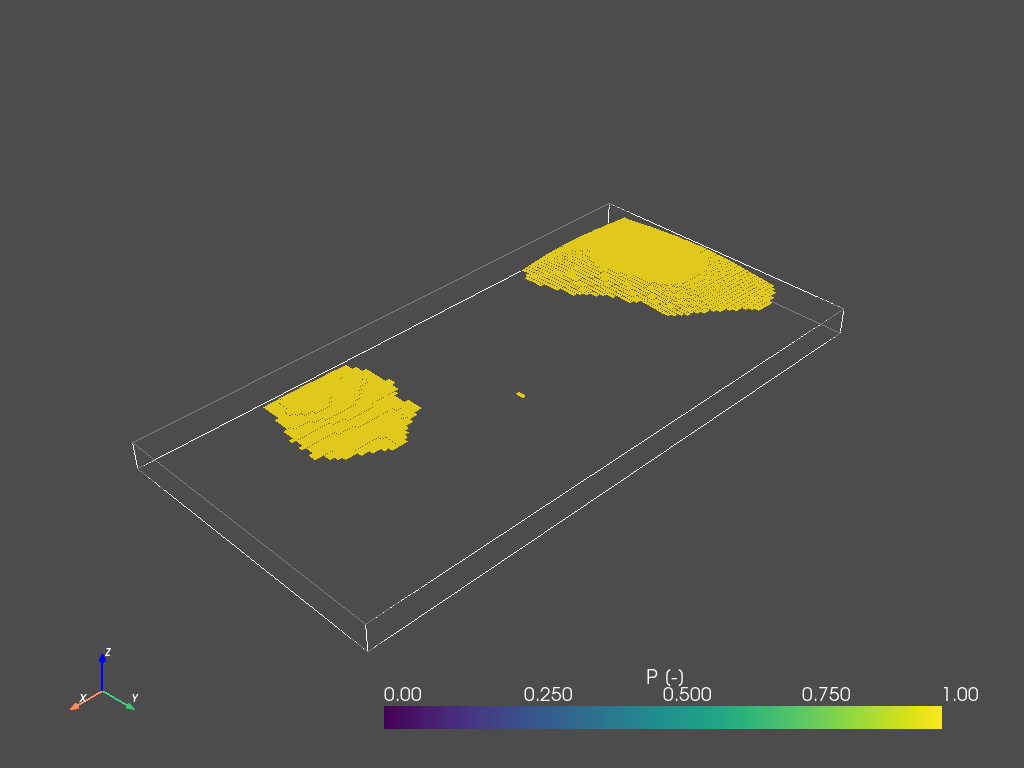

In [22]:
T1.plot_proba(C)

In [16]:
T1.compute_facies(1, verbose_methods=0)


### Unit D: facies simulation with TPGs method ####
### Unit D - realization 0 ###
Time elapsed 2.25 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
Time elapsed 0.1 s

### Unit B: facies simulation with SubPile method ####
SubPile filling method, nothing happened
Time elapsed 0.0 s

### Unit A: facies simulation with homogenous method ####
### Unit A - realization 0 ###
Time elapsed 0.02 s

### Unit B3: facies simulation with SIS method ####
### Unit B3 - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
Time elapsed 0.28 s

### Unit B2: facies simulation with SIS method ####
### Unit B2 - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
Time elapsed 0.21 s

### Unit B1: facies simulation with SIS method ####
### Unit B1 - realization 0 ###
Some errors have been found 
Some

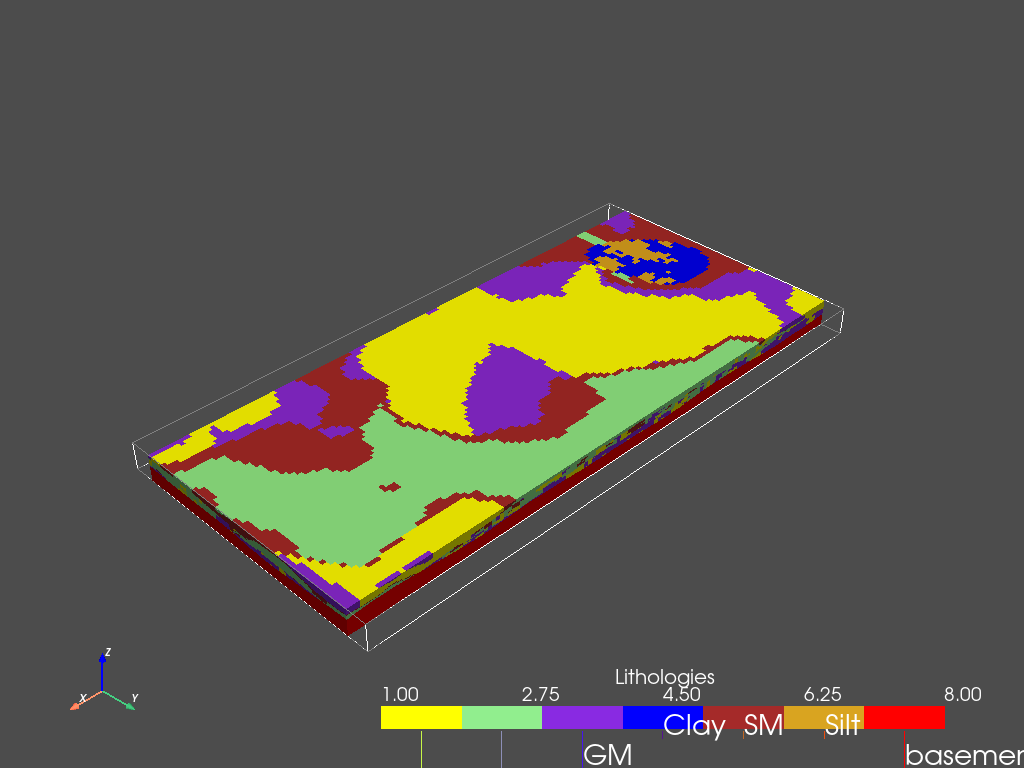

In [23]:
T1.plot_facies(v_ex=v_ex)

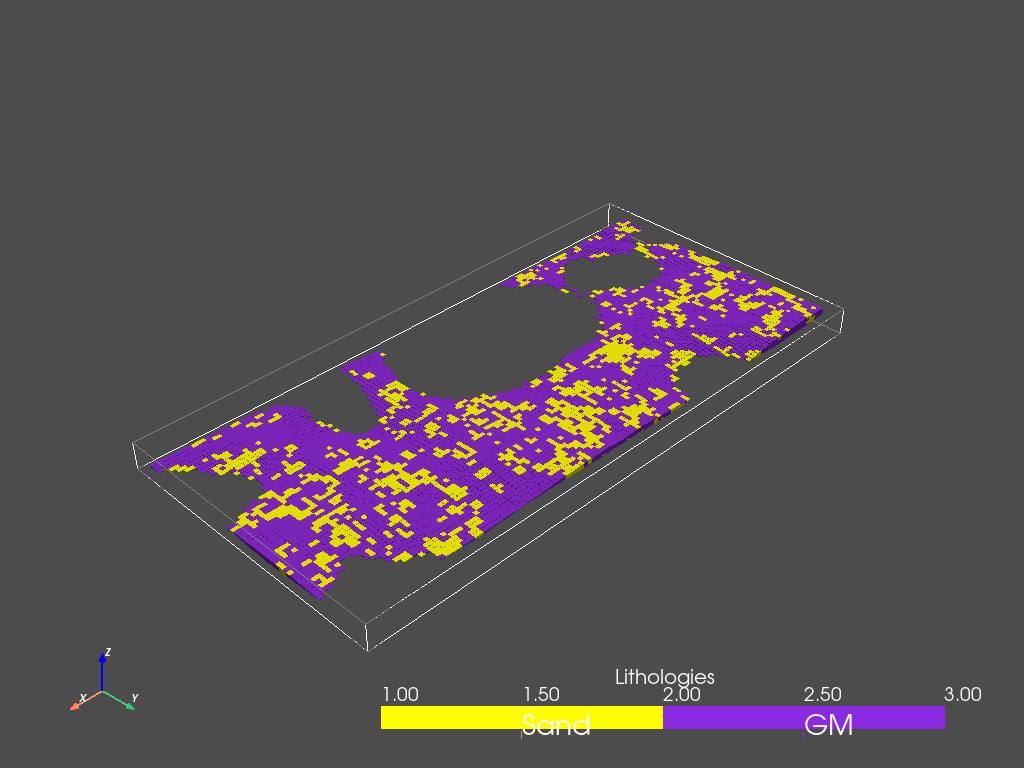

In [24]:
T1.plot_facies(0,0,inside_units=[B1], v_ex=v_ex)

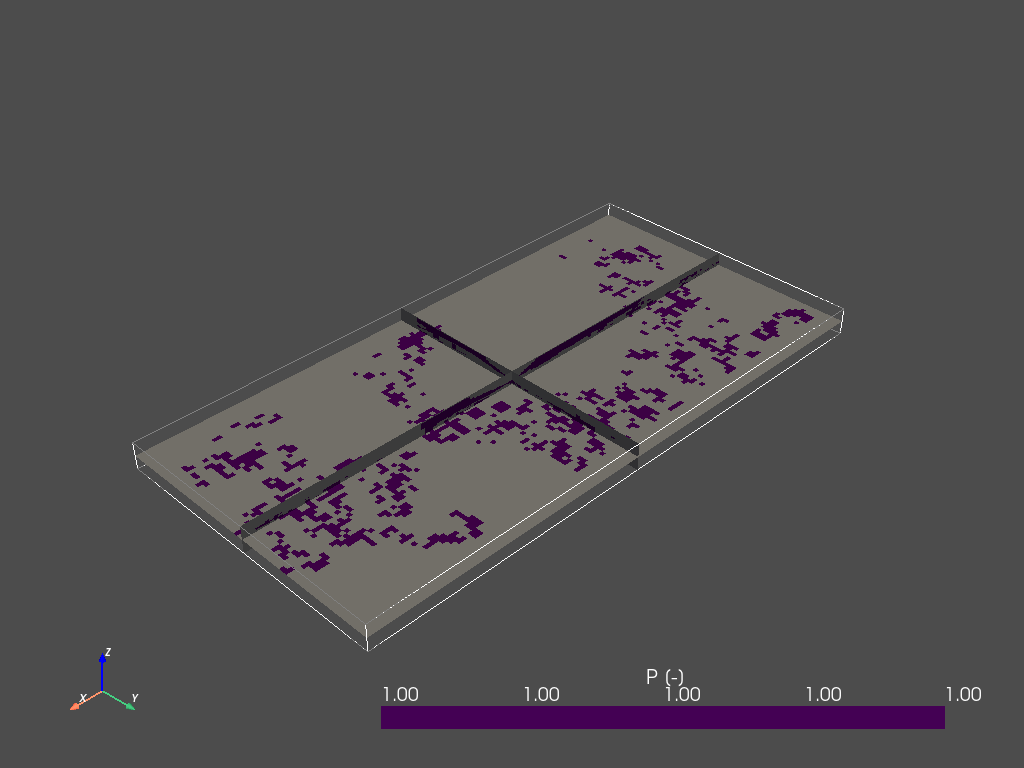

In [25]:
T1.plot_proba(facies_1,filtering_interval=[0.1,1],slicex=0.5,slicey=0.5,slicez=0.5, v_ex=v_ex) # sand

Property hard data can be passed by a list of coordinates and values

In [26]:
#prop hd

ix = np.arange(x0, nx*sx+x0, sx)
n = len(ix)
x_hd = np.array((ix, np.ones(n)*5, np.ones(n)*-10)).T
v = np.ones(n)*-1

In [27]:
permea.x = None
permea.v = None

In [28]:
permea.add_hd(x_hd, v)

In [29]:
T1.compute_prop(2)

### 2 K property models will be modeled ###
homogenous method chosen ! Warning: Some HD can be not respected
homogenous method chosen ! Warning: Some HD can be not respected
### 2 K models done


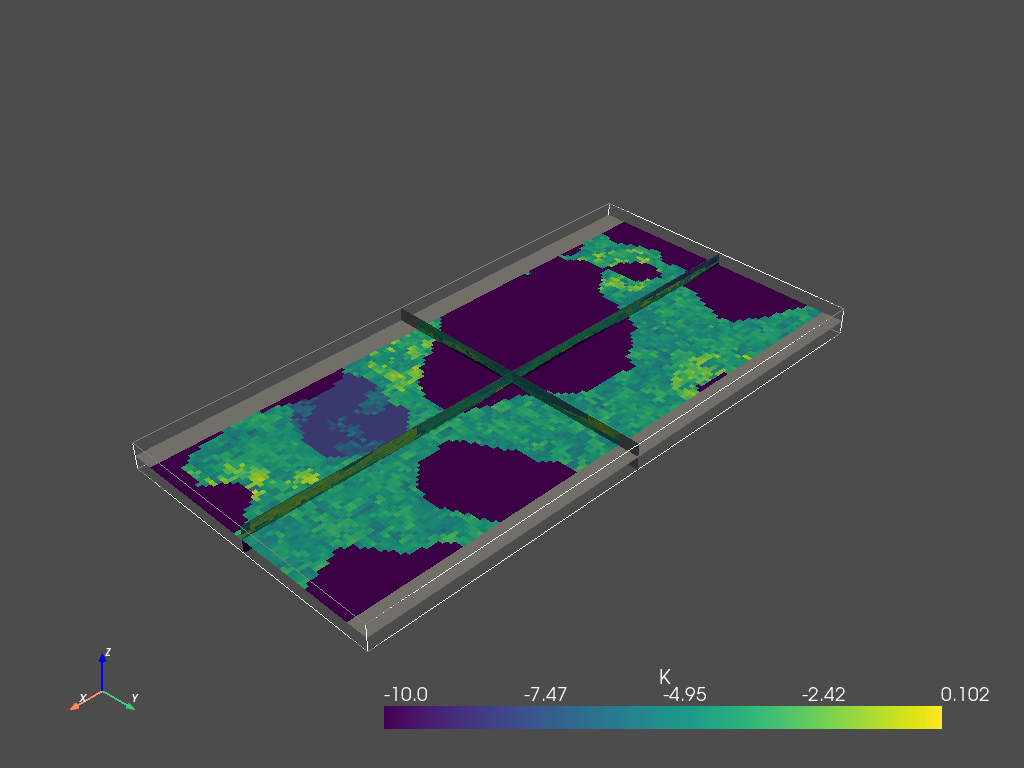

In [30]:
T1.plot_prop(permea.name, 0, slicex=0.5,slicey=0.5,slicez=0.5, v_ex=v_ex)

In [31]:
#property values can be retrieve with getprop method
K = T1.getprop("K")

In [32]:
#check HD
for x,y,z in x_hd:
    idx = T1.coord2cell(x, y, z)
    if idx is not None:
        print(K[2,0,0][idx])

#Some results are not respected (-10) due to the homogenous method applied on A unit

point outside of the grid in x


../..\ArchPy\base.py:5146: RuntimeWarning: Mean of empty slice
  arr=np.nanmean(prop.reshape(-1,self.get_nz(),self.get_ny(),self.get_nx()),axis=0)


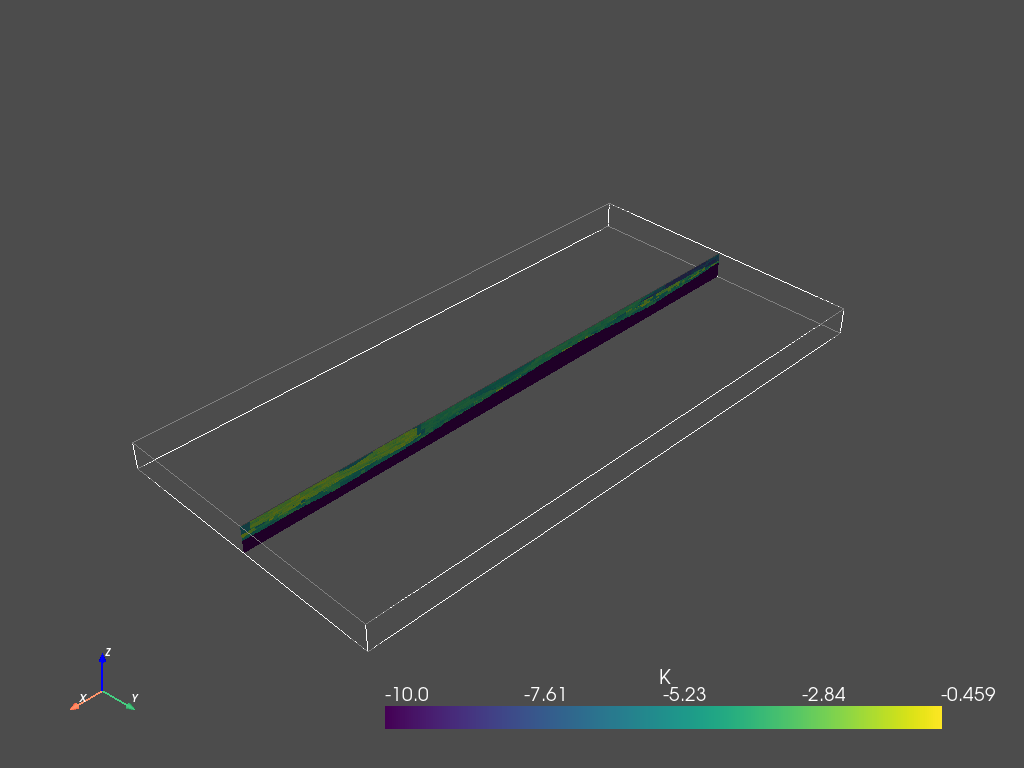

In [33]:
T1.plot_mean_prop("K", slicey = 0.5)

In [34]:
ArchPy.inputs.save_project(T1)

Project saved successfully


True

In [35]:
for i in T1.list_props[0].x:
    
    if hasattr(i, "__iter__"):
        print([float(o) for o in i])

[0.0, 5.0, -10.0]
[1.5, 5.0, -10.0]
[3.0, 5.0, -10.0]
[4.5, 5.0, -10.0]
[6.0, 5.0, -10.0]
[7.5, 5.0, -10.0]
[9.0, 5.0, -10.0]
[10.5, 5.0, -10.0]
[12.0, 5.0, -10.0]
[13.5, 5.0, -10.0]
[15.0, 5.0, -10.0]
[16.5, 5.0, -10.0]
[18.0, 5.0, -10.0]
[19.5, 5.0, -10.0]
[21.0, 5.0, -10.0]
[22.5, 5.0, -10.0]
[24.0, 5.0, -10.0]
[25.5, 5.0, -10.0]
[27.0, 5.0, -10.0]
[28.5, 5.0, -10.0]
[30.0, 5.0, -10.0]
[31.5, 5.0, -10.0]
[33.0, 5.0, -10.0]
[34.5, 5.0, -10.0]
[36.0, 5.0, -10.0]
[37.5, 5.0, -10.0]
[39.0, 5.0, -10.0]
[40.5, 5.0, -10.0]
[42.0, 5.0, -10.0]
[43.5, 5.0, -10.0]
[45.0, 5.0, -10.0]
[46.5, 5.0, -10.0]
[48.0, 5.0, -10.0]
[49.5, 5.0, -10.0]
[51.0, 5.0, -10.0]
[52.5, 5.0, -10.0]
[54.0, 5.0, -10.0]
[55.5, 5.0, -10.0]
[57.0, 5.0, -10.0]
[58.5, 5.0, -10.0]
[60.0, 5.0, -10.0]
[61.5, 5.0, -10.0]
[63.0, 5.0, -10.0]
[64.5, 5.0, -10.0]
[66.0, 5.0, -10.0]
[67.5, 5.0, -10.0]
[69.0, 5.0, -10.0]
[70.5, 5.0, -10.0]
[72.0, 5.0, -10.0]
[73.5, 5.0, -10.0]
[75.0, 5.0, -10.0]
[76.5, 5.0, -10.0]
[78.0, 5.0, -10.0]


In [36]:
i

array([198.,   5., -10.])